In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack
#import matplotlib as mpl
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology
from pyiga import assemble
#from patchmesh import *
from sksparse.cholmod import cholesky
#from patchmesh3D import *
#from multipatch import *
from pyiga import adaptive as adap
import json
from os.path import exists

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def draw_loglog_slope(fig, ax, origin, width_inches, slope, inverted=False, color=None, polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None):
    """
    This function draws slopes or "convergence triangles" into loglog plots.
    @param fig: The figure
    @param ax: The axes object to draw to
    @param origin: The 2D origin (usually lower-left corner) coordinate of the triangle
    @param width_inches: The width in inches of the triangle
    @param slope: The slope of the triangle, i.e. order of convergence
    @param inverted: Whether to mirror the triangle around the origin, i.e. whether 
        it indicates the slope towards the lower left instead of upper right (defaults to false)
    @param color: The color of the of the triangle edges (defaults to default color)
    @param polygon_kwargs: Additional kwargs to the Polygon draw call that creates the slope
    @param label: Whether to enable labeling the slope (defaults to true)
    @param labelcolor: The color of the slope labels (defaults to the edge color)
    @param label_kwargs: Additional kwargs to the Annotation draw call that creates the labels
    @param zorder: The z-order value of the triangle and labels, defaults to a high value
    """

    if polygon_kwargs is None:
        polygon_kwargs = {}
    if label_kwargs is None:
        label_kwargs = {}

    if color is not None:
        polygon_kwargs["color"] = color
    if "linewidth" not in polygon_kwargs:
        polygon_kwargs["linewidth"] = 0.75 * mpl.rcParams["lines.linewidth"]
    if labelcolor is not None:
        label_kwargs["color"] = labelcolor
    if "color" not in label_kwargs:
        label_kwargs["color"] = polygon_kwargs["color"]
    if "fontsize" not in label_kwargs:
        label_kwargs["fontsize"] = 0.75 * mpl.rcParams["font.size"]

    if inverted:
        width_inches = -width_inches
    if zorder is None:
        zorder = 10

    # For more information on coordinate transformations in Matplotlib see
    # https://matplotlib.org/3.1.1/tutorials/advanced/transforms_tutorial.html

    # Convert the origin into figure coordinates in inches
    origin_disp = ax.transData.transform(origin)
    origin_dpi = fig.dpi_scale_trans.inverted().transform(origin_disp)

    # Obtain the top-right corner in data coordinates
    corner_dpi = origin_dpi + width_inches * np.array([1.0, 0.0])
    corner_disp = fig.dpi_scale_trans.transform(corner_dpi)
    corner = ax.transData.inverted().transform(corner_disp)

    (x1, y1) = (origin[0], origin[1])
    x2 = corner[0]

    # The width of the triangle in data coordinates
    width = x2 - x1
    # Compute offset of the slope
    log_offset = y1 / (x1 ** (-slope))

    y2 = log_offset * (x2 ** (-slope))
    height = y2 - y1

    # The vertices of the slope
    a = origin
    b = corner
    c = [x2, y2]

    # Draw the slope triangle
    X = np.array([a, b, c])
    triangle = plt.Polygon(X[:3,:], fill=False, zorder=zorder, **polygon_kwargs)
    ax.add_patch(triangle)

    # Convert vertices into display space
    a_disp = ax.transData.transform(a)
    b_disp = ax.transData.transform(b)
    c_disp = ax.transData.transform(c)

    # Figure out the center of the triangle sides in display space
    bottom_center_disp = a_disp + 0.5 * (b_disp - a_disp)
    bottom_center = ax.transData.inverted().transform(bottom_center_disp)

    right_center_disp = b_disp + 0.5 * (c_disp - b_disp)
    right_center = ax.transData.inverted().transform(right_center_disp)

    # Label alignment depending on inversion parameter
    va_xlabel = "bottom" if not inverted else "top"
    ha_ylabel = "left" if not inverted else "right"

    # Label offset depending on inversion parameter
    offset_xlabel = [0.0, 0.33 * label_kwargs["fontsize"]] if not inverted else [0.0, -0.33 * label_kwargs["fontsize"]]
    offset_ylabel = [0.33 * label_kwargs["fontsize"], 0.0] if not inverted else [-0.33 * label_kwargs["fontsize"], 0.0]

    # Draw the slope labels
    ax.annotate("$1$", bottom_center, xytext=offset_xlabel, textcoords='offset points', ha="center", va=va_xlabel, zorder=zorder, **label_kwargs)
    ax.annotate(f"${slope}$", right_center, xytext=offset_ylabel, textcoords='offset points', ha=ha_ylabel, va="center", zorder=zorder, **label_kwargs)


In [3]:
#Geometries
def Lshape(deg, N):
 
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.unit_square().translate((-1,-1)),
        geometry.unit_square().translate((-1,0)),
        geometry.unit_square()
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)
    return M

def Fichera(deg,N):
    kvs = 7*(3 * (bspline.make_knots(deg, 0.0, 1.0, N),),)
    
    #define geometry
    geos = [
        geometry.unit_cube(),
        geometry.unit_cube().translate((0,0,-1)),
        geometry.unit_cube().translate((0,-1,0)),
        geometry.unit_cube().translate((-1,0,0)),
        geometry.unit_cube().translate((-1,-1,0)),
        geometry.unit_cube().translate((-1,0,-1)),
        geometry.unit_cube().translate((0,-1,-1)),
        geometry.unit_cube().translate((-1,-1,-1))
    ]
    
    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh3D(patches)
    return M

In [4]:
def adaptive(M, f, g, u=None, theta=0.9, maxiter=12, plotrange=(-1,1), draw=False, directory = '/home/wolfman/Pictures', return_P=False):
    params=dict()
    numdofs=np.zeros(maxiter)
    L2err=np.zeros(maxiter)
    H1err=np.zeros(maxiter)
    err_est=np.zeros(maxiter)
    err_ind=[]
    params['u_sol']=u
    params['ux']=ux
    params['uy']=uy
    refined=[]
    P=[]
    MP = assemble.Multipatch(M, automatch = True)
    
    for i in range(maxiter):
        print(i)
        if draw:
            fig = plt.figure()
            MP.mesh.draw(fig=fig)
            plt.axis('off')
            plt.axis('scaled');
            plt.savefig(directory + '/i'+str(i)+'.png',bbox_inches='tight')
            plt.close(fig)
            #plt.show()
        
        # ---------------------------------------------------------------------
        # SOLVE
        # ---------------------------------------------------------------------
        
        numdofs[i] = MP.numdofs
        #implement Dirichlet boundary conditions
        
#         print(MP.Basis.shape)
#         print(MP.numdofs)
        bcs = MP.compute_dirichlet_bcs({0:g})
        #print(bcs)

        # assemble the linear system
        Kh = MP.assemble_volume(vform.stiffness_vf(2))
        F = MP.assemble_volume(vform.L2functional_vf(2, physical=True), f=f[0])

        #eliminate boundary conditions
        LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
        #solve system and L2 project exact solution into discrete space
        uh = LS.complete((cholesky(LS.A.tocsc()))(LS.b))
        
        if u:
            Mh = MP.assemble_volume(vform.mass_vf(2))
            u_rhs = MP.assemble_volume(vform.L2functional_vf(2, physical=True),f=u)
            u_ = (cholesky(Mh.tocsc()))(u_rhs)
            #print(check_coupling(MP,u_))
        
            eh=uh-u_
            L2err[i] = sqrt(eh.T@Mh@eh)
            H1err[i] = sqrt(eh.T@Kh@eh + L2err[i]**2)
        
        # ---------------------------------------------------------------------
        # ESTIMATE AND REFINE
        # ---------------------------------------------------------------------
        
        if i < maxiter-1:
            start=time.time()
            err_ind.append(adap.PoissonEstimator(MP,uh,f))
            err_est[i] = norm(err_ind[-1])
            marked_patches = adap.doerfler_marking(err_ind[-1], theta)
            end = time.time()
            print("Estimate and Marking took " + str(end - start) + " seconds.")
            
            marked_patches = {p:None for p in marked_patches}
            refined.append(marked_patches)
            #print(MP.numdofs)
            start = time.time()
            P.append(MP.patch_refine(h_ref=marked_patches, return_P=True))
            end = time.time()
            print("Refinement took " + str(end - start) + " seconds.")
            
            start=time.time()
            MP = assemble.Multipatch(M, automatch = True)
            end = time.time()
            #MP.patch_refine(patches=marked_patches, return_prol=False)
            #MP.mesh.draw(patch_idx=True)
            #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]
        

    # restrict solution to each individual patch
    #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]

    #for (uh, ((kvs, geo),_)) in zip(uh, MP.mesh.patches):
        #vis.plot_field(uh, geo, vmin=plotrange[0], vmax=plotrange[1])
    #plt.axis('scaled')
    #plt.colorbar();
    
    return MP, uh, numdofs, L2err, H1err, err_est, err_ind, refined, P

In [5]:
def uniform(M, f, g, u=None, maxiter=12, plotrange=(-1,1), draw=False):
    params=dict()
    numdofs=np.zeros(maxiter)
    L2err=np.zeros(maxiter)
    H1err=np.zeros(maxiter)
    MP = assemble.Multipatch(M, automatch = True)
    
    for i in range(maxiter):
        print(i)
        if draw:
            MP.mesh.draw(bwidth=1)
            plt.axis('scaled');
            plt.show()
            
        numdofs[i] = MP.numdofs
        #implement Dirichlet boundary conditions
        
#         print(MP.Basis.shape)
#         print(MP.numdofs)
        bcs = MP.compute_dirichlet_bcs({0:g})
        #print(bcs)

        # assemble the linear system
        #Kh, F = MP.assemble_system(vform.stiffness_vf(2), vform.L2functional_vf(2, physical=True), f=f)
        
        Kh = MP.assemble_volume(vform.stiffness_vf(2))
        F = MP.assemble_volume(vform.L2functional_vf(2, physical=True), f=f[0])
        
        #eliminate boundary conditions
        LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
        #solve system and L2 project exact solution into discrete space
        uh = LS.complete((cholesky(LS.A.tocsc()))(LS.b))
        
        if u:
            Mh = MP.assemble_volume(vform.mass_vf(2))
            u_rhs = MP.assemble_volume(vform.L2functional_vf(2, physical=True),f=u)
            u_ = (cholesky(Mh.tocsc()))(u_rhs)
            #print(check_coupling(MP,u_))
        
            eh=uh-u_
            L2err[i] = sqrt(eh.T@Mh@eh)
            H1err[i] = sqrt(eh.T@Kh@eh + L2err[i]**2)
            
        if i < maxiter-1:
            start=time.time()
            MP.patch_refine(h_ref=-1)
            end=time.time()
            print("Refinement took " + str(end - start) + " seconds.")
            MP = assemble.Multipatch(M, automatch = True)
    #MP.plot(uh)
        
    return MP, uh, numdofs, L2err, H1err

In [6]:
def cart2pol(x, y):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(r, phi%(2*pi))
def u(x,y):
    r, phi = cart2pol(x,y)
    return r**(2/3)*sin(2*phi/3)
def ux(x,y):
    r, phi = cart2pol(x,y)
    return -2./3*r**(-1./3)*sin(phi/3)
def uy(x,y):
    r, phi = cart2pol(x,y)
    return 2./3*r**(-1./3)*cos(phi/3)

f=lambda x,y: 0.

In [7]:
def L_Test(deg=2):
    M = Lshape(deg,deg+1)
    MP, uh, numdofs, L2err, H1err = uniform(M,f={0:f},g=u,u=u, maxiter=7, draw=False)
    if not exists('Lp'+str(deg)+'n'+str(deg+1)+'.txt'):
        M = Lshape(deg,deg+1)
        MP_a, uh_a, numdofs_a, L2err_a, H1err_a, err_est, err_ind, refined = adaptive(M, f={0:f}, g=u, u=u, draw=True, maxiter=23, theta=0.9, directory = '/home/wolfman/Pictures/Lshape_p'+ str(deg))
    else:
        data = np.loadtxt('Lp'+str(deg)+'n'+str(deg+1)+'.txt')
        numdofs_a,H1err_a,L2err_a,err_est=data

    fig, ax = plt.subplots()
    plt.loglog(numdofs_a, H1err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
    plt.loglog(numdofs, H1err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
    plt.loglog(numdofs_a[:-1], err_est[:-1], 'x-',color='red',linewidth=0.5, markerfacecolor='none')
    plt.legend(['adaptively refined mesh','uniformly refined mesh','error estimator'],loc='lower left',prop={'size': 8})
    plt.xlabel("N$_{dof}$")
    draw_loglog_slope(fig,ax,(2*1e4,1e-4),2, int(deg/2) if deg%2==0 else deg/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
    draw_loglog_slope(fig,ax,(1e4,0.8*1e-2),2,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
    ax.set_xlim([5*1e1, 1e6]) 
    #axis('scaled');
    plt.savefig('/home/wolfman/Pictures/Lshape_p2/Lp'+str(deg)+'n'+str(deg+1)+'H1_cnv.pdf', bbox_inches='tight')
    plt.show()

In [123]:
deg=2
M = Lshape(deg,deg+1)
MP, uh, numdofs, L2err, H1err = uniform(M,f={0:f},g=u,u=u, maxiter=7, draw=False)
# M.draw()

0
Refinement took 0.011157989501953125 seconds.
1
Refinement took 0.012854337692260742 seconds.
2
Refinement took 0.022521495819091797 seconds.
3
Refinement took 0.058385372161865234 seconds.
4
Refinement took 0.18683290481567383 seconds.
5
Refinement took 0.5726542472839355 seconds.
6


In [129]:
deg=2
M = Lshape(deg,deg+1)
MP_a, uh_a, numdofs_a, L2err_a, H1err_a, err_est, err_ind, refined = adaptive(M, f={0:f}, g=u, u=u, draw=True, maxiter=23, theta=0.9, directory = '/home/wolfman/Pictures/Lshape_p'+ str(deg))
#M.draw()
np.savetxt('Lp'+str(deg)+'n'+str(deg+1)+'.txt', np.c_[[numdofs_a,H1err_a,L2err_a,err_est]])

0
Residual contributions took 0.019089698791503906 seconds.
Jump contributions took 0.0097198486328125 seconds.
Estimate and Marking took 0.028931379318237305 seconds.
Refinement took 0.008658647537231445 seconds.
1
Residual contributions took 0.07549214363098145 seconds.
Jump contributions took 0.08457589149475098 seconds.
Estimate and Marking took 0.16024446487426758 seconds.
Refinement took 0.010670661926269531 seconds.
2
Residual contributions took 0.13229632377624512 seconds.
Jump contributions took 0.1968674659729004 seconds.
Estimate and Marking took 0.32934045791625977 seconds.
Refinement took 0.012601375579833984 seconds.
3
Residual contributions took 0.18447136878967285 seconds.
Jump contributions took 0.2970147132873535 seconds.
Estimate and Marking took 0.48192286491394043 seconds.
Refinement took 0.015521049499511719 seconds.
4
Residual contributions took 0.24107646942138672 seconds.
Jump contributions took 0.3998537063598633 seconds.
Estimate and Marking took 0.6411914825

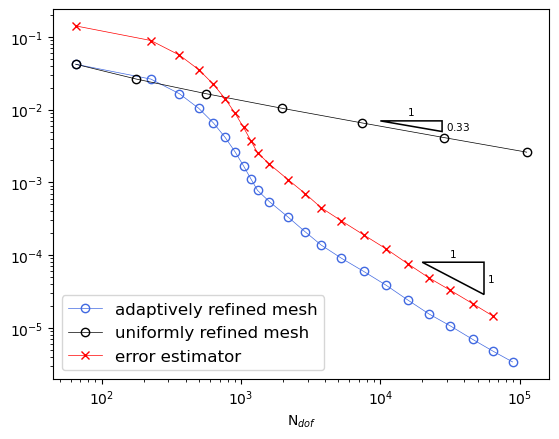

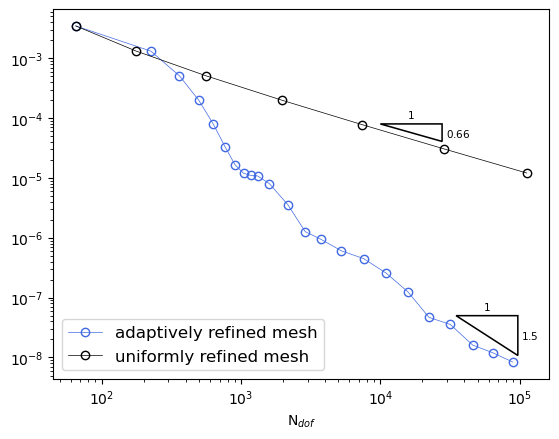

In [126]:
deg=2
numdofs_a,H1err_a,L2err_a,err_est=np.loadtxt('Lp'+str(deg)+'n'+str(deg+1)+'.txt').reshape((4,23))

fig, ax = plt.subplots()
plt.loglog(numdofs_a, H1err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, H1err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], err_est[:-1], 'x-',color='red',linewidth=0.5, markerfacecolor='none')

plt.legend(['adaptively refined mesh','uniformly refined mesh','error estimator'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")
draw_loglog_slope(fig,ax,(2*1e4,0.8*1e-4),2, int(deg/2) if deg%2==0 else deg/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e4,0.7*1e-2),2,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
# ax.set_xlim([1e1,1e5]);
# ax.set_ylim([1e-8,0.3]);
#axis('scaled');
plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'H1_cnv.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs_a, L2err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, L2err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], '^-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[16:22],[0.001/n**(1) for n in numdofs_a[16:22]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(2/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptively refined mesh','uniformly refined mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")
draw_loglog_slope(fig,ax,(3.5*1e4,0.5*1e-7),2,slope=(deg+1)/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e4,0.8*1e-4),2,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
#axis('scaled');
plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'L2_cnv.pdf', bbox_inches='tight')
plt.show()

In [127]:
deg=3
M = Lshape(deg,deg+1)
MP, uh, numdofs, L2err, H1err = uniform(M,f={0:f},g=u,u=u, maxiter=7, draw=False)
#M.draw()

0
Refinement took 0.011533260345458984 seconds.
1
Refinement took 0.015743494033813477 seconds.
2
Refinement took 0.043193817138671875 seconds.
3
Refinement took 0.09062981605529785 seconds.
4
Refinement took 0.2777078151702881 seconds.
5
Refinement took 1.0024986267089844 seconds.
6


In [11]:
deg=3
M = Lshape(deg,deg+1)
MP_a, uh_a, numdofs_a, L2err_a, H1err_a, err_est, err_ind, refined = adaptive(M, f={0:f}, g=u, u=u, draw=True, maxiter=29, theta=0.9, directory = '/home/wolfman/Pictures/Lshape_p'+ str(deg))
#M.draw()
np.savetxt('Lp3n4.txt', np.c_[[numdofs_a,H1err_a,L2err_a,err_est]])

0
Residual contributions took 0.01990485191345215 seconds.
Jump contributions took 0.01005864143371582 seconds.
Estimate and Marking took 0.030113697052001953 seconds.
Refinement took 0.03360462188720703 seconds.
1
Residual contributions took 0.055631399154663086 seconds.
Jump contributions took 0.06228280067443848 seconds.
Estimate and Marking took 0.11806488037109375 seconds.
Refinement took 0.05655097961425781 seconds.
2
Residual contributions took 0.09042692184448242 seconds.
Jump contributions took 0.12840676307678223 seconds.
Estimate and Marking took 0.2190077304840088 seconds.
Refinement took 0.10717940330505371 seconds.
3
Residual contributions took 0.14394831657409668 seconds.
Jump contributions took 0.28348422050476074 seconds.
Estimate and Marking took 0.4276430606842041 seconds.
Refinement took 0.13760972023010254 seconds.
4
Residual contributions took 0.1958479881286621 seconds.
Jump contributions took 0.3290543556213379 seconds.
Estimate and Marking took 0.52542018890380

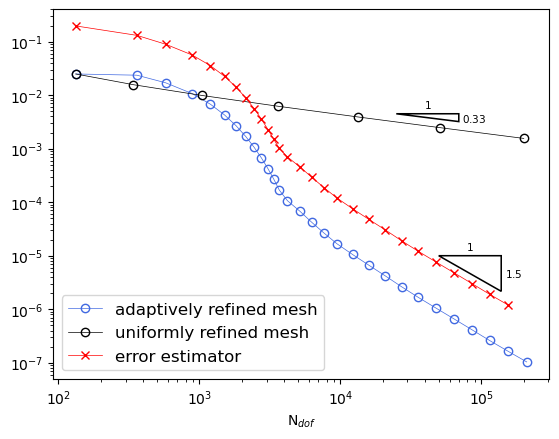

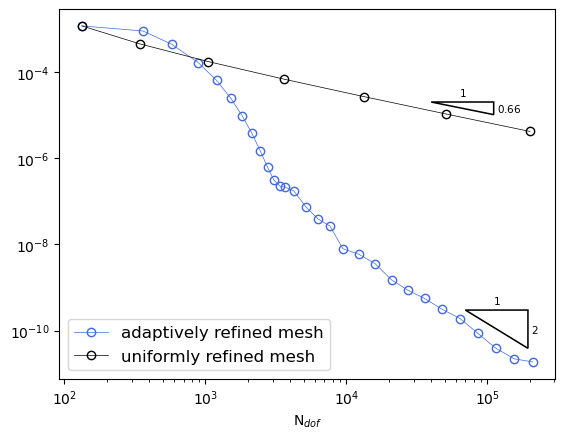

In [128]:
deg=3
numdofs_a,H1err_a,L2err_a,err_est=np.loadtxt('Lp'+str(deg)+'n'+str(deg+1)+'.txt').reshape((4,29))

fig, ax = plt.subplots()
plt.loglog(numdofs_a, H1err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, H1err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], err_est[:-1], 'x-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[19:25],[0.2/n**(1) for n in numdofs_a[19:25]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(1/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptively refined mesh','uniformly refined mesh','error estimator'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")
draw_loglog_slope(fig,ax,(0.5*1e5,1e-5),2,int(deg/2) if deg%2==0 else deg/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(0.25*1e5,4.5*1e-3),2,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
# ax.set_xlim([1,1e7]);
# ax.set_ylim([1e-8,0.3]);
# axis('scaled');
plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'H1_cnv.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs_a, L2err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, L2err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], '^-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[16:22],[0.001/n**(1) for n in numdofs_a[16:22]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(2/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptively refined mesh','uniformly refined mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")
draw_loglog_slope(fig,ax,(0.7*1e5,0.3*1e-9),2,slope=2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(4*1e4,2*1e-5),2,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
#axis('scaled');
plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'L2_cnv.pdf', bbox_inches='tight')
plt.show()

In [129]:
deg=4
M = Lshape(deg,deg+1)
MP, uh, numdofs, L2err, H1err = uniform(M,f={0:f},g=u,u=u, maxiter=7, draw=False)
#M.draw()

0
Refinement took 0.012837886810302734 seconds.
1
Refinement took 0.03476285934448242 seconds.
2
Refinement took 0.07718729972839355 seconds.
3
Refinement took 0.15015125274658203 seconds.
4
Refinement took 0.40928220748901367 seconds.
5
Refinement took 1.5374345779418945 seconds.
6


In [196]:
M = Lshape(deg,deg+1)
MP_a, uh_a, numdofs_a, L2err_a, H1err_a, err_est, err_ind, refined = adaptive(M, f={0:f}, g=u, u=u, draw=True, maxiter=40,  directory = '/home/wolfman/Pictures/Lshape_p'+ str(deg))
#M.draw()
np.savetxt('Lp'+str(deg)+'n'+str(deg+1)+'.txt', np.c_[[numdofs_a,H1err_a,L2err_a,err_est]])

0
Residual contributions took 0.01728081703186035 seconds.
Jump contributions took 0.00911259651184082 seconds.
Estimate and Marking took 0.02650618553161621 seconds.
Refinement took 0.008128881454467773 seconds.
1
Residual contributions took 0.0704183578491211 seconds.
Jump contributions took 0.08855128288269043 seconds.
Estimate and Marking took 0.15915131568908691 seconds.
Refinement took 0.01634383201599121 seconds.
2
Residual contributions took 0.16025304794311523 seconds.
Jump contributions took 0.18680787086486816 seconds.
Estimate and Marking took 0.3472409248352051 seconds.
Refinement took 0.012916326522827148 seconds.
3
Residual contributions took 0.17431998252868652 seconds.
Jump contributions took 0.29109644889831543 seconds.
Estimate and Marking took 0.46571803092956543 seconds.
Refinement took 0.015337228775024414 seconds.
4
Residual contributions took 0.22942709922790527 seconds.
Jump contributions took 0.3941988945007324 seconds.
Estimate and Marking took 0.623885154724

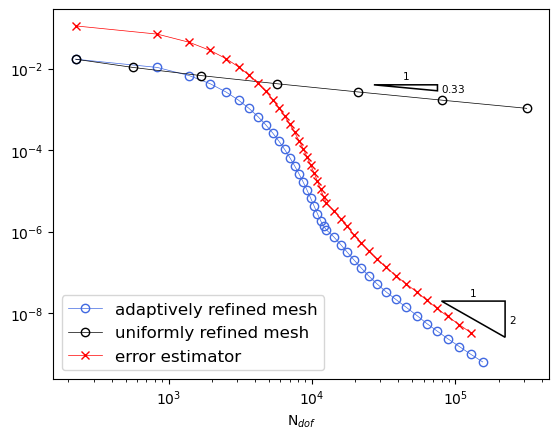

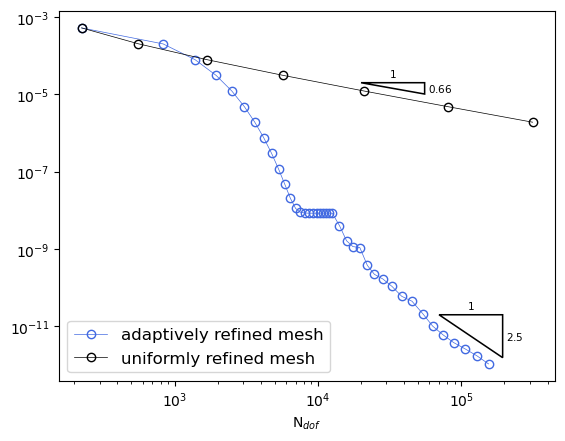

In [130]:
deg=4
numdofs_a,H1err_a,L2err_a,err_est=np.loadtxt('Lp'+str(deg)+'n'+str(deg+1)+'.txt').reshape((4,40))

fig, ax = plt.subplots()
plt.loglog(numdofs_a, H1err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, H1err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], err_est[:-1], 'x-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[19:25],[0.2/n**(1) for n in numdofs_a[19:25]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(1/3) for n in numdofs[3:6]],linestyle='--')
#plt.legend(['adaptive','uniform','error estimator'],loc='lower left',prop={'size': 12})
plt.legend(['adaptively refined mesh','uniformly refined mesh','error estimator'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")
draw_loglog_slope(fig,ax,(0.8*1e5,0.2*1e-7),2,2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(2.7*1e4,0.4*1e-2),2,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
#axis('scaled');
plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'H1_cnv.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs_a, L2err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, L2err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], '^-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[16:22],[0.001/n**(1) for n in numdofs_a[16:22]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(2/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptively refined mesh','uniformly refined mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")
draw_loglog_slope(fig,ax,(0.7*1e5,0.2*1e-10),2,slope=2.5,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(2*1e4,2*1e-5),2,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
#axis('scaled');
plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'L2_cnv.pdf', bbox_inches='tight')
plt.show()

In [9]:
def dist(x,y):
    condlist = [np.bitwise_and(x>=0,y>=0), np.bitwise_and(x<0,y>0), np.bitwise_and(x<0,y<=0)]
    choicelist = [np.amin([1-x,y,1-y],axis=0), np.amin([1+x,1-y,np.sqrt(x**2+y**2)],axis=0), np.amin([1+y,1+x,-x],axis=0)]
    return np.select(condlist, choicelist, 0.)

In [151]:
x=np.array([0.1])
y=np.array([0.9])

In [152]:
dist(x,y)

array([0.1])

In [143]:
np.amin([1-x,y,1-y],axis=0)

array([0.1])

In [178]:
M=Lshape(2,10)
MP=assemble.Multipatch(M, automatch=True)

In [179]:
u_=MP.L2projection(lambda x,y: dist(x,y)**2)

AttributeError: 'Figure' object has no attribute 'get_array'

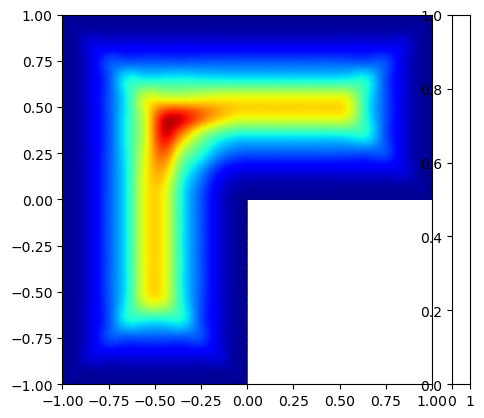

In [180]:
MP.plot(plt.figure(),u_)

In [55]:
deg=2
M = Lshape(deg,deg+1)
maxiter=10
MP_a, uh_a, numdofs_a, L2err_a, H1err_a, err_est, err_ind, refined, P = adaptive(M, f={0:lambda x,y: 1.}, g=0., draw=False, maxiter=maxiter,  directory = '/home/wolfman/Pictures/Lshape_p'+ str(deg)+'corner', return_P=True)

0
Residual contributions took 0.019937992095947266 seconds.
Jump contributions took 0.009733915328979492 seconds.
Estimate and Marking took 0.02978825569152832 seconds.
Refinement took 0.06191277503967285 seconds.
1
Residual contributions took 0.07382345199584961 seconds.
Jump contributions took 0.0821678638458252 seconds.
Estimate and Marking took 0.1561450958251953 seconds.
Refinement took 0.11415410041809082 seconds.
2
Residual contributions took 0.1263432502746582 seconds.
Jump contributions took 0.18245959281921387 seconds.
Estimate and Marking took 0.30896902084350586 seconds.
Refinement took 0.16659283638000488 seconds.
3
Residual contributions took 0.18229365348815918 seconds.
Jump contributions took 0.2861659526824951 seconds.
Estimate and Marking took 0.4686923027038574 seconds.
Refinement took 0.21500325202941895 seconds.
4
Residual contributions took 0.2380671501159668 seconds.
Jump contributions took 0.3935203552246094 seconds.
Estimate and Marking took 0.6318416595458984 

In [56]:
P_p = MP_a.patch_refine(h_ref={}, p_ref=3, return_P = True)
bcs = MP_a.compute_dirichlet_bcs({0:0})
Mh_p = MP_a.assemble_volume(vform.mass_vf(2))
Kh_p = MP_a.assemble_volume(vform.stiffness_vf(2))
F_p = MP_a.assemble_volume(vform.L2functional_vf(2, physical=True), f=lambda x,y: 1.)
LS = assemble.RestrictedLinearSystem(Kh_p, F_p, bcs)
uh_p = LS.complete((cholesky(LS.A))(LS.b))

for i in range(len(P)):
    for k in range(i):
        P[k]=P[i]@P[k]
        
for i in range(len(P)):
    P[i]=P_p@P[i]

/tmp/ipykernel_10331/2610513949.py:7: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  uh_p = LS.complete((cholesky(LS.A))(LS.b))


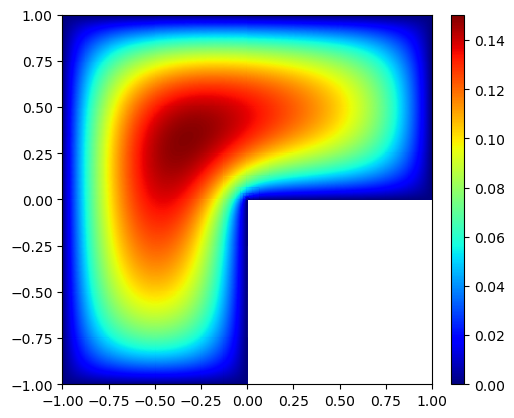

In [58]:
MP_a.plot(uh_p)

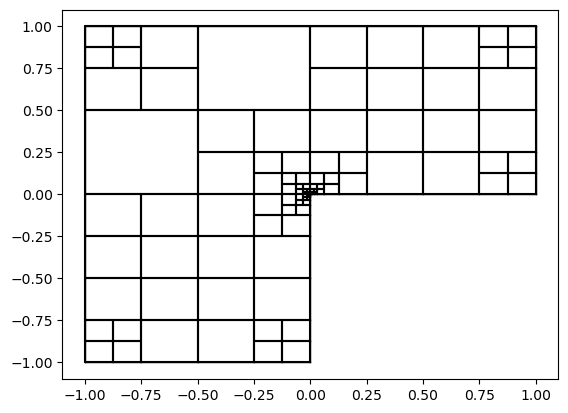

In [66]:
MP_a.mesh.draw(plt.figure(),knots=None)

In [63]:
deg=2
M=Lshape(deg,deg+1)
MP = assemble.Multipatch(M, automatch=True)
L2err_a=np.zeros(maxiter-1)
H1err_a=np.zeros(maxiter-1)
numdofs_a=np.zeros(maxiter-1)

for i in range(len(refined)):
    bcs = MP.compute_dirichlet_bcs({0:0})
    Kh = MP.assemble_volume(vform.stiffness_vf(2))
    F = MP.assemble_volume(vform.L2functional_vf(2, physical=True), f=lambda x,y: 1.)
    LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
    uh = LS.complete((cholesky(LS.A))(LS.b))
        
    eh=P[i]@uh-uh_p
    L2err_a[i] = sqrt(eh.T@Mh_p@eh)
    H1err_a[i] = sqrt(eh.T@Kh_p@eh + L2err_a[i]**2)
    numdofs_a[i]=MP.numdofs
    if i < len(refined)-1:
            MP.patch_refine(h_ref=refined[i])
#np.savetxt('Lp'+str(deg)+'n'+str(deg+1)+'corner.txt', np.c_[[numdofs_a,H1err_a,L2err_a,err_est]])

/tmp/ipykernel_10331/2181293258.py:13: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  uh = LS.complete((cholesky(LS.A))(LS.b))


In [65]:
L2err_a

array([0.00495, 0.00464, 0.0044 , 0.00417, 0.00396, 0.0038 , 0.00349, 0.00289, 0.00226])

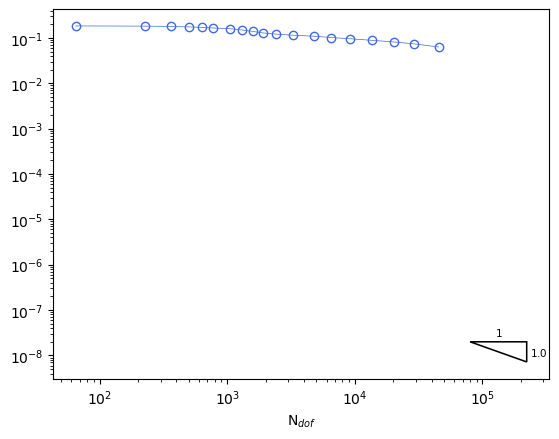

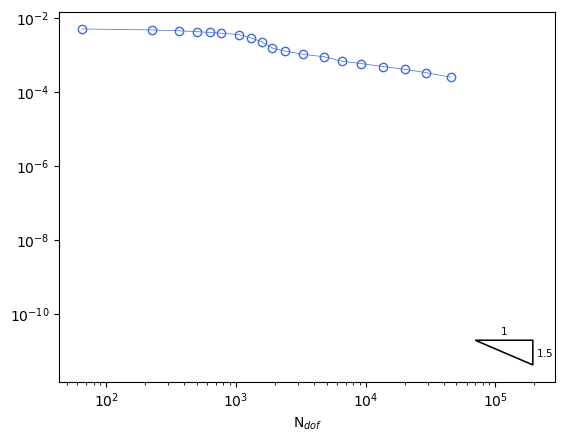

In [54]:
#numdofs_a,H1err_a,L2err_a,err_est=np.loadtxt('Lp'+str(deg)+'n'+str(deg+1)+'.txt').reshape((4,maxiter))

fig, ax = plt.subplots()
plt.loglog(numdofs_a, H1err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs, H1err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a, err_est[:-1], 'x-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[19:25],[0.2/n**(1) for n in numdofs_a[19:25]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(1/3) for n in numdofs[3:6]],linestyle='--')
#plt.legend(['adaptive','uniform','error estimator'],loc='lower left',prop={'size': 12})
#plt.legend(['adaptively refined mesh','uniformly refined mesh','error estimator'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")
draw_loglog_slope(fig,ax,(0.8*1e5,0.2*1e-7),2,deg/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
#draw_loglog_slope(fig,ax,(2.7*1e4,0.4*1e-2),2,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
#axis('scaled');
#plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'H1_cnv.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs_a, L2err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs, L2err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], '^-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[16:22],[0.001/n**(1) for n in numdofs_a[16:22]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(2/3) for n in numdofs[3:6]],linestyle='--')
#plt.legend(['adaptively refined mesh','uniformly refined mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")
draw_loglog_slope(fig,ax,(0.7*1e5,0.2*1e-10),2,slope=(deg+1)/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
#draw_loglog_slope(fig,ax,(2*1e4,2*1e-5),2,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
#axis('scaled');
#plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'L2_cnv.pdf', bbox_inches='tight')
plt.show()

In [8]:
deg=3
M = Lshape(deg,deg+1)
MP_a, uh_a, numdofs_a, L2err_a, H1err_a, err_est, err_ind, refined = adaptive(M, f={0:lambda x,y: 1.}, g=0., draw=True, maxiter=28,  directory = '/home/wolfman/Pictures/Lshape_p'+ str(deg)+'corner')
#M.draw()

0
Residual contributions took 0.03342914581298828 seconds.
Jump contributions took 0.013004064559936523 seconds.
Estimate and Marking took 0.04657292366027832 seconds.
Refinement took 0.005409955978393555 seconds.
1
Residual contributions took 0.0531919002532959 seconds.
Jump contributions took 0.06096673011779785 seconds.
Estimate and Marking took 0.11431145668029785 seconds.
Refinement took 0.006279945373535156 seconds.
2
Residual contributions took 0.08703470230102539 seconds.
Jump contributions took 0.1213076114654541 seconds.
Estimate and Marking took 0.20848798751831055 seconds.
Refinement took 0.010599613189697266 seconds.
3
Residual contributions took 0.14086413383483887 seconds.
Jump contributions took 0.22470521926879883 seconds.
Estimate and Marking took 0.3657855987548828 seconds.
Refinement took 0.019217252731323242 seconds.
4
Residual contributions took 0.19464492797851562 seconds.
Jump contributions took 0.3225066661834717 seconds.
Estimate and Marking took 0.51753830909

In [9]:
deg=4
M = Lshape(deg,deg+1)
MP_a, uh_a, numdofs_a, L2err_a, H1err_a, err_est, err_ind, refined = adaptive(M, f={0:lambda x,y: 1.}, g=0., draw=True, maxiter=34,  directory = '/home/wolfman/Pictures/Lshape_p'+ str(deg)+'corner')
#M.draw()

0
Residual contributions took 0.019983768463134766 seconds.
Jump contributions took 0.008594036102294922 seconds.
Estimate and Marking took 0.028684377670288086 seconds.
Refinement took 0.007750272750854492 seconds.
1
Residual contributions took 0.07012510299682617 seconds.
Jump contributions took 0.0813131332397461 seconds.
Estimate and Marking took 0.1515820026397705 seconds.
Refinement took 0.010030984878540039 seconds.
2
Residual contributions took 0.11753082275390625 seconds.
Jump contributions took 0.171173095703125 seconds.
Estimate and Marking took 0.2888526916503906 seconds.
Refinement took 0.011797666549682617 seconds.
3
Residual contributions took 0.16527700424194336 seconds.
Jump contributions took 0.27478528022766113 seconds.
Estimate and Marking took 0.44033026695251465 seconds.
Refinement took 0.01496267318725586 seconds.
4
Residual contributions took 0.21259427070617676 seconds.
Jump contributions took 0.3766806125640869 seconds.
Estimate and Marking took 0.589466333389

In [218]:
def compute_active_constr(Constr):
    #fast variant
    
    a=(Constr>1e-12).sum(axis=1); b=(Constr<-1e-12).sum(axis=1)
    activeConstraints=np.where(a+b>0)[0]
    sign = np.where(b==1 & a>0)
    
    signs=1.*((a<=1) | (a+b==0))-1.*((a>1)&(a+b>0))
    #print(signs)
    S=scipy.sparse.spdiags(signs,0,len(a),len(a))
    
    Constr = S@Constr
    
    # assert np.all(((a[activeConstraints]==1) | (b[activeConstraints]==1))), 'error in constraint matrix.'

    #variant 1
    # activeConstraints=[]
    # for r in range(Constr.shape[0]):
    #     a = 0
    #     b = 0
    #     for ind in range(Constr.indptr[r], Constr.indptr[r+1]):
    #         if Constr.data[ind] > 1e-12:
    #             a += 1
    #         if Constr.data[ind] < -1e-12:
    #             b += 1
    #     if a+b>0:
    #         activeConstraints.append(r)
    #         #print("{}: {}, {}".format(r,a,b))
    #         #if not (a==1 or b==1): 
    #             #print(a,b)
    #             #print(Constr[r,:])
    #         #assert (a==1 or b==1), 'error in constraint matrix.'
    #         if b==1 and a>0:
    #             #print( "Re-sign" )
    #             Constr[r,:] *= -1
                
    return np.array(activeConstraints)

In [219]:
C=scipy.sparse.csr_matrix(np.array([[0,0,0,0],[0.5,-1,0,0.5],[0.5,0.5,-0.5,-0.5]]))

In [220]:
compute_active_constr(C)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [214]:
print(C.A)

[[ 0.   0.   0.   0. ]
 [-0.5  1.   0.  -0.5]
 [ 0.5  0.5 -0.5 -0.5]]
